# Testing custom geometry

In [6]:
import tensorflow as tf
from tensorflow import keras
from keras.models import model_from_json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import json
import os

In [7]:
Start,End = 14,20
for i in range(Start,End):
    i1,i2=str(i),str(i+1)
    if i < 18:
        V2 = '_V2'
    else:
        V2 = ''
    root_url = f"Data/CA-DBB_HH_20{i1}01010000_20{i2}01010000{V2}.csv"
    df = pd.read_csv(root_url,parse_dates=['TIMESTAMP_START'],na_values=-9999)
    df = df.set_index('TIMESTAMP_START')
    if i == Start:
        Data = df.copy()
    else:
        Data = pd.concat(
            [Data,df]
        )

def Calc_VPD(TA, RH):
    # Calculate vapour pressure (hPa)
    # From TA (in celsius) and RH %
    ea_H = 0.61365*np.exp((17.502*TA)/(240.97+TA))
    e_H = RH*ea_H/100
    VPD = ea_H - e_H
    VPD = np.round(VPD*10,5)     # Limit precision
    return (VPD)
    
Data['VPD'] = Calc_VPD(Data['TA'],Data['RH'])

print(Data.columns)
Data[['CO2', 'FC', 'FCH4', 'RH', 'TA', 'NETRAD', 'SW_IN', 'LW_OUT', 
    'P', 'TS_1_1_1', 'TS_1_2_1', 'TS_1_3_1', 'WTD','WS','USTAR'
       ]].describe()

Index(['TIMESTAMP_END', 'CO2', 'FC', 'G', 'H', 'LE', 'WD', 'WS', 'USTAR', 'PA',
       'RH', 'TA', 'NETRAD', 'SW_IN', 'SW_OUT', 'LW_IN', 'LW_OUT', 'P',
       'T_SONIC', 'TS_1_1_1', 'TS_1_2_1', 'TS_1_3_1', 'WTD', 'FC_F', 'H_F',
       'LE_F', 'FCH4', 'VPD'],
      dtype='object')


,CO2,FC,FCH4,RH,TA,NETRAD,SW_IN,LW_OUT,P,TS_1_1_1,TS_1_2_1,TS_1_3_1,WTD,WS,USTAR
count,64827.000000,36765.000000,21877.000000,72252.000000,69838.000000,69104.000000,69539.000000,94472.000000,94412.000000,94752.000000,94765.000000,94482.000000,76679.000000,78954.000000,64379.000000
mean,441.575387,-0.787144,70.509587,82.563969,10.573513,81.035552,141.675786,370.937518,0.064427,12.007551,11.873606,11.621711,-0.077961,1.591783,0.166553
std,58.072862,2.796263,68.674930,16.013128,6.882273,178.738082,231.592218,43.751411,0.259551,5.535256,5.319778,3.673522,0.118576,1.392520,0.118031
min,208.022000,-73.607700,-199.641000,17.466101,-11.491303,-103.800000,0.000000,256.399170,0.000000,0.510000,0.770000,3.940000,-0.382820,0.000000,0.000275
25%,407.113500,-2.157400,17.800000,72.570000,5.969827,-23.091879,0.000000,340.963219,0.000000,6.959365,6.980000,8.025305,-0.169714,0.420000,0.069700
50%,422.280000,-0.506306,60.100000,87.711371,10.370411,-1.540000,3.410000,364.989000,0.000000,12.212890,12.188600,11.951013,-0.040143,1.320000,0.143569
75%,455.819000,0.562361,114.710000,95.787075,15.180000,119.402900,194.664058,393.540000,0.000000,17.070000,16.810000,15.050000,0.021700,2.400000,0.240735
max,986.500000,90.341600,687.649000,100.500000,32.430000,851.450000,1076.680000,521.450000,8.600000,25.354000,23.047600,17.421900,0.119653,12.090000,3.078190


In [45]:
Model_Vars = {
            'Radiation':['SW_IN','LW_IN','SW_OUT','LW_OUT'],
            'Temperature':['TS_1_1_1','TS_1_2_1','WTD'],
            'Wind':['USTAR'],
            'Target':['FC']
            }
Model_Vars = {
            'GPP':['SW_IN','VPD'],
            'ER':['TS_1_1_1','TS_1_2_1','WTD'],
            'Transport':['WS','USTAR'],
            'Target':['FC']
            }

# Model_Vars = {
#             'All':['SW_IN','LW_IN','SW_OUT','LW_OUT','TS_1_1_1','TS_1_2_1','USTAR'],
#             'Target':['FC']
#             }
            
Training_Data = Data[[item for sublist in Model_Vars.values() for item in sublist]].dropna()
Training_Data.describe()

,SW_IN,VPD,TS_1_1_1,TS_1_2_1,WTD,WS,USTAR,FC
count,22507.000000,22507.000000,22507.000000,22507.000000,22507.000000,22507.000000,22507.000000,22507.000000
mean,278.804638,5.238862,13.965031,13.724442,-0.080351,2.226353,0.219204,-0.854020
std,287.742758,4.865254,4.753583,4.595957,0.104644,1.255941,0.104191,2.270654
min,0.000000,-0.000000,1.980000,1.970000,-0.352014,0.000000,0.038100,-26.186100
25%,0.200000,1.556815,10.470000,10.435063,-0.153225,1.340000,0.136987,-2.335980
50%,185.580000,3.826680,16.057787,15.823780,-0.066100,2.107050,0.213911,-0.609723
75%,507.747065,7.524595,17.540000,17.182341,0.012233,2.960000,0.287025,0.619422
max,1076.680000,35.789140,21.910000,20.860000,0.072483,9.820000,0.916834,21.763700


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 GPP (InputLayer)               [(None, 2)]          0           []                               
                                                                                                  
 ER (InputLayer)                [(None, 3)]          0           []                               
                                                                                                  
 Transport (InputLayer)         [(None, 2)]          0           []                               
                                                                                                  
 GPP_dense1 (Dense)             (None, 20)           60          ['GPP[0][0]']                    
                                                                                              

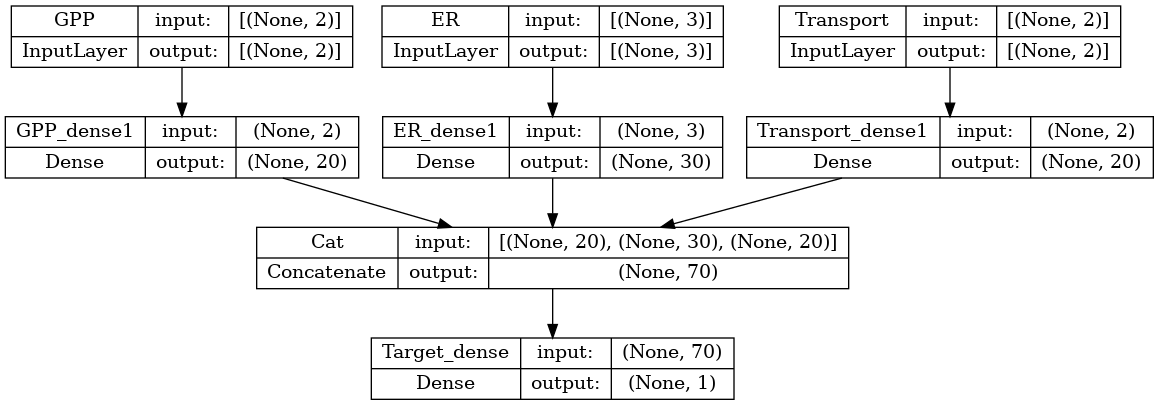

In [46]:
def make_model(Model_Vars,hidden_nodes,name='Model'):
    try:
        os.mkdir(f"temp_files/{name}")
    except:
        pass
    tf.keras.backend.clear_session()
    Inputs = []
    Layers = []
    for key in Model_Vars.keys():
        if key != 'Target':
            shape = len(Model_Vars[key])
            Inputs.append(
                keras.layers.Input(shape,name=key)
                )
            Hidden = keras.layers.Dense(
                                    shape*hidden_nodes,
                                    activation='relu',
                                    kernel_initializer="glorot_uniform",
                                    bias_initializer="zeros",
                                    name=key+'_dense1'
                                    )(Inputs[-1])
            Layers.append(Hidden)
                # keras.layers.Dense(
                #                     shape,
                #                     name=key+'_dense2'
                #                     )(Hidden)
                #                     )
    if len(Layers) > 1:
        Out = keras.layers.Concatenate(
                                        axis=1,
                                        name='Cat'
                                        )(Layers)
        Out = keras.layers.Dense(1,name='Target_dense')(Out)
    else:
        Out = keras.layers.Dense(1,name='Target_dense')(Layers[0])

    model = keras.models.Model(inputs=Inputs, outputs=Out)

    model_json = model.to_json()
    with open(f"temp_files/{name}/model_architecture.json", "w") as json_file:
        json_file.write(model_json)
    return(model)

Train = []
Target = Training_Data[Model_Vars['Target']].values
for key in Model_Vars.keys():
    if key != 'Target':
        Train.append(Training_Data[Model_Vars[key]].values)
    
model = make_model(Model_Vars,10,name='NewModel')
print(model.summary())
keras.utils.plot_model(model, show_shapes=True)


Epoch 1: val_loss improved from inf to 7.50380, saving model to temp_files/NewModel/best_model.h5

Epoch 2: val_loss improved from 7.50380 to 3.10861, saving model to temp_files/NewModel/best_model.h5

Epoch 3: val_loss improved from 3.10861 to 2.68177, saving model to temp_files/NewModel/best_model.h5

Epoch 4: val_loss improved from 2.68177 to 2.51427, saving model to temp_files/NewModel/best_model.h5

Epoch 5: val_loss did not improve from 2.51427

Epoch 6: val_loss improved from 2.51427 to 2.50075, saving model to temp_files/NewModel/best_model.h5

Epoch 7: val_loss did not improve from 2.50075

Epoch 8: val_loss improved from 2.50075 to 2.47425, saving model to temp_files/NewModel/best_model.h5

Epoch 9: val_loss did not improve from 2.47425

Epoch 10: val_loss improved from 2.47425 to 2.41860, saving model to temp_files/NewModel/best_model.h5

Epoch 11: val_loss improved from 2.41860 to 2.31964, saving model to temp_files/NewModel/best_model.h5

Epoch 12: val_loss did not improv

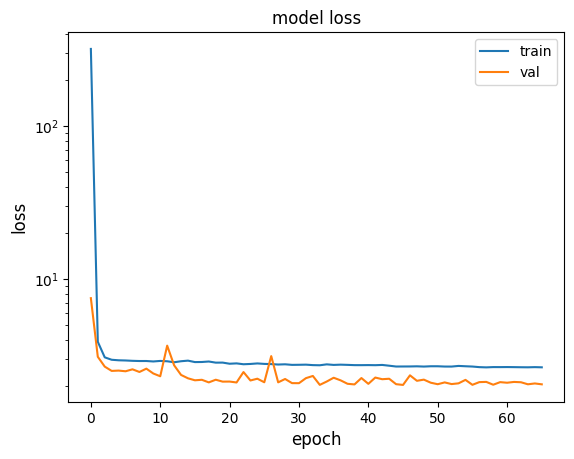

704/704 [==============================] - 1s 2ms/step
0.5111356646780931
1.587579346736141


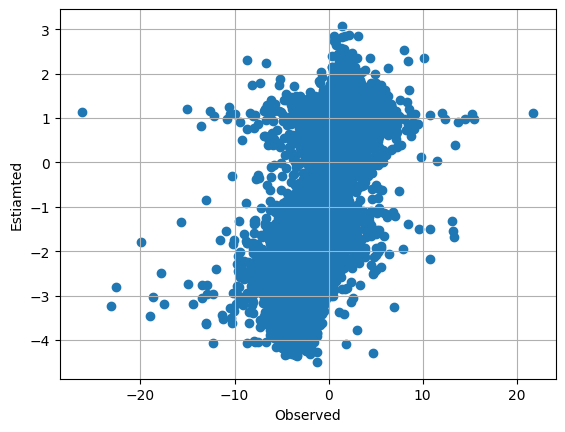

In [47]:
epochs = 250
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "temp_files/NewModel/best_model.h5", 
        save_best_only=True, monitor="val_loss", verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=10, min_lr=0.00001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, verbose=2),
]

model.compile(
    optimizer="adam",
    loss="mean_squared_error",
)

history = model.fit(
    Train,
    Target,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=0,
)

metric = "loss"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.yscale('log')
plt.show()
plt.close()

pred = model.predict(Train)

fig,ax=plt.subplots()
ax.scatter(Target,pred)
ax.set_ylabel('Estiamted')
ax.set_xlabel('Observed')
ax.grid()
print(metrics.r2_score(Target,pred))
print(metrics.mean_squared_error(Target,pred)**.5)

In [48]:

with open(f"temp_files/NewModel/model_architecture.json", 'r') as json_file:
    architecture = json.load(json_file)
    model = model_from_json(json.dumps(architecture))
model = keras.models.load_model("temp_files/NewModel/best_model.h5")

Layers = architecture['config']['layers']
# print('Layers: ',Layers)

Metadata = {}
for L in Layers:
    if L['class_name']=='Dense':
        var_set = L['name'].split('_')[0]
        if var_set not in Metadata.keys():
            Metadata[var_set] = {}
        Metadata[var_set][L['name']] = {}
        # Metadata[L['name']]['Var_Set']  = 
        Metadata[var_set][L['name']]['activation'] = L['config']['activation']

for i, L in enumerate(model.weights):
    # print(L)
    # print(Layers)
    var_lyr = L.name.split('/')[0]
    var_set = var_lyr.split('_')[0]
    typ = L.name.split('/')[1]
    # Metadata[var_set][var_lyr][typ]={}
    # Metadata[var_set][var_lyr][typ]['shape'] = L.numpy().shape
    Metadata[var_set][var_lyr][typ] = i

Metadata


{'GPP': {'GPP_dense1': {'activation': 'relu', 'kernel:0': 0, 'bias:0': 1}},
 'ER': {'ER_dense1': {'activation': 'relu', 'kernel:0': 2, 'bias:0': 3}},
 'Transport': {'Transport_dense1': {'activation': 'relu',
   'kernel:0': 4,
   'bias:0': 5}},
 'Target': {'Target_dense': {'activation': 'linear',
   'kernel:0': 6,
   'bias:0': 7}}}

In [49]:
GPP = tf.convert_to_tensor((Train[0]))
ER = tf.convert_to_tensor((Train[1]))
Transport = tf.convert_to_tensor((Train[2]))
with tf.GradientTape(persistent=True) as tape:
    tape.watch([GPP,ER,Transport])
    
    # Forward pass.
    pred = model([GPP,ER,Transport])

    # # Loss value for this batch.
    # loss = loss_fn(y, pred)

# # Get gradients of the loss wrt the weights.
# gradients = tape.gradient(loss, Model.trainable_weights)


# Get gradients of the pred wrt x
dy_dx = tape.gradient(pred,[GPP,ER,Transport])
for d in dy_dx:
    print(d.numpy().shape)

(22507, 2)
(22507, 3)
(22507, 2)


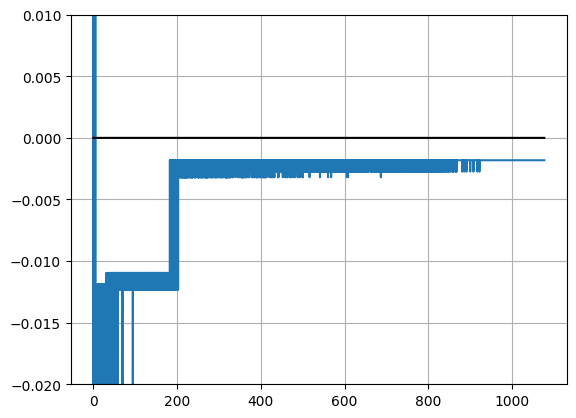

In [63]:
Temp = pd.DataFrame(data = {
    'SW':GPP.numpy()[:,0],
    'dFC_dSW':dy_dx[0][:,0]
}).sort_values(by='SW')

plt.figure()
plt.plot(Temp['SW'],Temp['dFC_dSW'])
plt.plot(Temp['SW'],Temp['dFC_dSW']*0,color='k')
plt.ylim(-.02,.01)
plt.grid()

In [95]:
def activation_func(activation,H):
    if activation == 'relu':
        Out = np.maximum(H,np.zeros(H.shape))
    elif activation == 'sigmoid':
        Out = 1/(1+np.exp(-H))
    elif activation == 'linear':
        Out = H
    return(Out)
        
#     # First derivative of the relu function
#     # If using Sigmoid function, change to - 

def get_derivs(Data,Model_Vars,Metadata,weights):
    Target = Model_Vars['Target']
    for i in range(1):#Data[Target].shape[0]):
        print()
        H = []
        for key in Model_Vars.keys():
            # print(key)
            if key != 'Target':
                IP = Data[Model_Vars[key]].values[i]
                for lyr in Metadata[key].keys():
                    kernel = weights[Metadata[key][lyr]['kernel:0']].numpy()
                    bias = weights[Metadata[key][lyr]['kernel:0']].numpy()
                    activation = Metadata[key][lyr]['activation']
                    H1 = (IP*kernel.T).sum(axis=-1)+bias
                    activation_func(activation,H1)
                    H.append(H1.shape)
        # H = np.array(H)
        print(H)
                # for var in Model_Vars[key]:
                #     print(var)
    #                 print(Metadata[key][lyr]['activation'])
    #                 print(Metadata[key][lyr]['kernel:0'])
    #                 print(Metadata[key][lyr]['bias:0'])

get_derivs(Training_Data,Model_Vars,Metadata,model.weights)


[(5, 50), (3, 30), (3, 30)]


In [ ]:
W = model.get_weights()
print(len(W))
for w in W:
    print(w.shape)

# W_i_ER = (W[0])
# W_i_ER_T = (W[0].T)

# W_i_GPP = (W[2])
# W_i_GPP_T = (W[2].T)

# W_d_i_ER = (W[1])
# W_d_i_GPP = (W[3])

# W_d_o_ER = (W[4])
# W_d_o_ER_T = (W[4].T)

# W_d_o_GPP = (W[6])
# W_d_o_GPP_T = (W[6].T)

# W_o_ER = (W[5])
# W_o_GPP = (W[7])

# # w_do_i = (W[8])
# # w_do_o = (W[9])


# Op_GPP = []
# for i in range(y_train_NEE.shape[0]):
#     Ip_GPP = x_train_GPP[i]
#     H1_GPP = (Ip_GPP*W_i_GPP_T).sum(axis=-1)+W_d_i_GPP
#     # First derivative of the relu function
#     # If using Sigmoid function, change to - H1 = 1/(1+np.exp(-H1))
#     H1_GPP = np.maximum(H1_GPP,np.zeros(H1_GPP.shape))
#     H2_GPP = (H1_GPP*W_d_o_GPP_T).sum(axis=-1)+W_o_GPP
#     # H2_GPP = np.maximum(H2_GPP,np.zeros(H2_GPP.shape))
#     Op_GPP.append(H2_GPP)# - .diagonal()  needed if doing multiple models at onece 
# Estimates_GPP = np.array(Op_GPP)


# Op_ER = []
# for i in range(y_train_NEE.shape[0]):
#     Ip_ER = x_train_ER[i]
#     H1_ER = (Ip_ER*W_i_ER_T).sum(axis=-1)+W_d_i_ER
#     # First derivative of the relu function
#     # If using Sigmoid function, change to - H1 = 1/(1+np.exp(-H1))
#     H1_ER = np.maximum(H1_ER,np.zeros(H1_ER.shape))
#     H2_ER = (H1_ER*W_d_o_ER_T).sum(axis=-1)+W_o_ER
#     # H2_ER = np.maximum(H2_ER,np.zeros(H2_ER.shape))
#     Op_ER.append(H2_ER)# - .diagonal()  needed if doing multiple models at onece 
# Estimates_ER = np.array(Op_ER)

# Estimates_NEE = Estimates_ER+Estimates_GPP

# # Estimates_NEE = (Estimates_NEE*w_do_i).sum(axis=-1)+w_do_o

# fig,axes=plt.subplots(2,2,figsize=(8,8))
# ax = axes[0,0]
# ax.scatter(pred,Estimates_NEE)
# ax.set_title('NEE')

# ax = axes[0,1]
# ax.scatter(Estimates_ER,Estimates_GPP)
# ax.set_title('ER x GPP')

# ax = axes[1,0]
# ax.scatter(x_train_GPP[:,0],Estimates_GPP,c=x_train_GPP[:,1])
# ax.set_title('SW IN x GPP')

# ax = axes[1,1]
# ax.scatter(x_train_ER[:,0],Estimates_ER,c=x_train_ER[:,1])
# ax.set_title('TA x ER')

# plt.tight_layout()

In [ ]:
SSD = []
SAD = []
Derivs = []
# print(W_d_o_GPP.shape)
for i in range(x_train_GPP.shape[1]):
    dj_GPP=[]
    for j in range(y_train_NEE.shape[0]):
        target = y_train_NEE[j]
        Xj = x_train_GPP[j][i]
        if np.isnan(target)==False:
            H1_GPP = (Xj*W_i_GPP_T).sum(axis=-1)+W_d_i_GPP
            AD = np.maximum(H1_GPP,np.zeros(H1_GPP.shape))
            AD[AD>0]=1
            # Sum = np.array([AD[h]*W_d_o_GPP[h]*W_i_GPP[i,h] for h in range(W_d_o_GPP.shape[0])]).sum(axis=0)
            # print(Sum)
            # print(AD.shape,W_d_o_GPP.shape,W_i_GPP[i].shape)
            Sum = (AD*W_d_o_GPP[:,0]*W_i_GPP[i]).sum(axis=0)
            # print(Sum)
            Sj = 1
            dj_GPP.append(Sj*Sum)
    dji_GPP = np.array(dj_GPP)#*w_do_i
    print(dji_GPP.shape)
    Derivs.append(dji_GPP)



for i in range(x_train_ER.shape[1]):
    dj_ER=[]
    for j in range(y_train_NEE.shape[0]):
        target = y_train_NEE[j]
        Xj = x_train_ER[j][i]
        if np.isnan(target)==False:
            H1_ER = (Xj*W_i_ER_T).sum(axis=-1)+W_d_i_ER
            AD = np.maximum(H1_ER,np.zeros(H1_ER.shape))
            AD[AD>0]=1
            # Sum = np.array([AD[h]*W_d_o_ER[h]*W_i_ER[i,h] for h in range(W_d_o_ER.shape[0])]).sum(axis=0)
            Sum = (AD*W_d_o_ER[:,0]*W_i_ER[i]).sum(axis=0)
            # print(Sum)
            Sj = 1
            dj_ER.append(Sj*Sum)
    # print(dj_GPP.mean())
    dji_ER = np.array(dj_ER)#*w_do_i
    print(dji_ER.shape)
    Derivs.append(dji_ER)

#     SSD.append(np.sum(dji**2,axis=0))
#     SAD.append(np.sum(np.abs(dji),axis=0))
# Derivs = np.array(Derivs)
# SSD = np.array(SSD)
# RI_SSD = SSD/SSD.sum(axis=0)
# SAD = np.array(SAD)
# RI_SAD = SAD/SAD.sum(axis=0)

In [ ]:

for d in Derivs:
    
    print(d.shape)
    print()
fig,ax=plt.subplots(figsize=(8,8))
ax.scatter(x_train_ER[:,0],Derivs[4])
# ax.set_xlim(-1,1)
ax.grid()

In [98]:
a = np.array([[1,1],[1,0]])
b = np.array([[3,3],[3,3]])

print('Mult')
c = a*b
print(c)

print()
print('Dot')
d = np.dot(a,b)
print(d)

Mult
[[3 3]
 [3 0]]

Dot
[[6 6]
 [3 3]]
